# Introduction 
In this code we're going to wok through an extended example that demonstrates how randomization inference works. As noted in the lecture, we are working through the example of a randomized assignment of men and women to eat (or not eat) soybeans and we are measuring the level of estrogen present in each of their bloodstreams (perhaps in parts/million).


First, we create a grouping variable with two groups, one called "Man", and another called "Woman". 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.DataFrame(
  {'group': np.repeat(a=['man', 'woman'], repeats=20)
  })
df.tail()

,group
35,woman
36,woman
37,woman
38,woman
39,woman


To these groups, we assign silly, but schematically heplful *potential outcomes* to treatment and control. We say that, by some chance, we sampled men into our study that had estrogen ppm levels that ranged from 1-20, in perfect increments. Also, what luck, but we sampled women into the study that had estrogen levels that ranged from 51-70. So, the women have on average higher estrogen beginning the study. 


In [3]:
df['po_control'] = np.concatenate(
    [np.arange(1,21), np.arange(51,71)], 
    axis=None)
df['po_treat'] = df['po_control'] # no effect because potential outcome are the same 
df.head()

,group,po_control,po_treat
0,man,1,1
1,man,2,2
2,man,3,3
3,man,4,4
4,man,5,5


Per our randomization scheme, we are going to randomly assign the individuals to either: 

- eat lots of tofu `(treatment == 1)`; or, 
- do not eat tofu `(treatment == 0)`. 

To do this, we write a simple function that will randomly place zeros and ones for the treatment and control. 


In [4]:
def randomize(): 
    urn = np.repeat([0,1], repeats=20)
    np.random.shuffle(urn)
    return(urn)

With our randomization function in hand, we can now "**run an experiment** which is going to: 

1. Assign people to treatment or control; 
2. If they're in treatment, we will see their potential outcomes to treatment; and, 
3. If they're in contorl, we will see their potential outcomes to control. 

Functionally, this is simply storing the results of our function randomize in a vector object called treatment, and then recording the correct potential outcome value. 

In [5]:
def run_experiment(): 
    df['treat'] = randomize()
    
    df['Y'] = 0
    df.loc[df['treat']==0, 'Y'] = df.loc[df['treat']==0, 'po_control']
    df.loc[df['treat']==1, 'Y'] = df.loc[df['treat']==1, 'po_treat']
    
    return(df[['group', 'treat', 'Y']])

In [6]:
df = run_experiment()
df.tail()

,group,treat,Y
35,woman,1,66
36,woman,0,67
37,woman,1,68
38,woman,0,69
39,woman,0,70


Recall that we are setting up an experiment that has **no** effect. As Green and Gerber point out in *Field Experiments* in the case of the sharp-null, we are actually testing against the possiblity that we observe both the potential outcoems! Cool.

Next, we create a vector of realized outcomes, first using the compact notation that Green and Gerber prefer using maths. For those randomized to treamtent, we multiply the potential outcome to treatment time the treatment vector (which is a 1 when they were assigned to treatment), and for those in control, into this vector we assign the potential outcome to control time the quantity `(1 - treatment)` which will be one when they are in the treatment group. 

# Ok so we've got our data set up. Now what? 
Now that we have the data set up, we can begin to examine what the lecture is really about, what is the distribution of ATE that we observe due to the different possibly assignments to treatment and control. A few points to remember: 

1. From last week: The difference in sample means between the treatment and control groups is an unbiased estimator of the ATE. 
2. Also from last week: This does not imply that any one realization of treatment/control assignment is guaranteed to exactly produce that ATE.

This is the entire point of understanding the distribution of the ATE. 

To get here, first lets write another function that will calculate the ATE. 


In [7]:
def estimate_ate(df): 
    res = df[['treat', 'Y']].groupby('treat').mean()
    ate = res.diff()['Y'][1]
    
    return(ate)

In [8]:
ate = estimate_ate(df)
ate

-9.5999999999999979

In [12]:
df[['group', 'treat']].groupby('group').mean()

,treat
group,
man,0.6
woman,0.4


**What gives!** 

We created this data such that there is *exactly* zero treament effect, but when we look at this summary of the outcomes, they're not **exactly** the same! *Shouldn't they have been?* 

Note, even more specifically than creating the data so that there was no *average treatment effect* we constructed this so that there was no effect at all -- this is at the potential outcomes level! Recall that P(0) = P(1).  


What happens if you go back to the top and run the experiment again? Are the numbers internally consistent, even if they're producing a result that doesn't seem to make sense? 

## Question of Understanding 
Why are these values different each time you run your experiment? 

## More Work with this 

Lets rewrite our function just slightly so that rather than pulling the results frame, instead we're pulling the estimated average treatment effect from the experiment. This is just going to index into the values, and compute the difference between them. 

In [13]:
def sim_experiment(_df = df, result=True): 
    if result: 
        _df['treat'] = randomize()
        res = _df[['treat', 'Y']].groupby('treat').mean()
        res = res.diff()
        return(res.iloc[1]['Y'])
    else: 
        _df['treat'] = randomize()
        res = _df[['treat', 'Y']].groupby('treat').mean()
        res = res.diff()
        print("The ate under the sharp null is:", res.iloc[1]['Y'].astype('int'))     

In [14]:
sim_experiment(result=False)

The ate is: -13


In [15]:
sim_experiment(result=False)

The ate is: -10


In [16]:
sim_experiment(result=False)

The ate is: 5


What we're seeing is that there are some slightly different outcomes to different trement regimes. 

We can do this, a bunch more times using some simple list comprehension. Specifically, do this 5,000 times to get a sense of the distribution. 


In [20]:
experiments = [sim_experiment(result=True) for _ in range(0,5000)]

In [18]:
experiments[0:10]

[-2.0999999999999943,
 0.29999999999999716,
 -1.0,
 5.0999999999999943,
 -3.5999999999999943,
 10.799999999999997,
 -7.5999999999999979,
 4.4000000000000057,
 -2.2000000000000028,
 -9.2000000000000028]

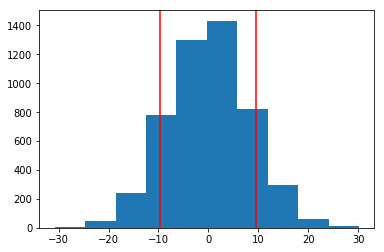

In [26]:
%matplotlib inline

plt.hist(experiments)
plt.axvline(x=ate, color = 'red')
plt.axvline(x = -1 * ate, color = 'red')

As it turns out, that was pretty similar to what we saw in our draw! In fact, what we've got here is pretty likely to turn up by chance. 

Following David B. statment, we can really easily draw a probability of seeing an ATE of a given size under the repeated randomization regime. 

For how many of these randomization inference loops, was the *randomization inference* ate more negative than the ate? 


In [42]:
def p_value(ate, experiments): 
    if np.sign(ate) == -1: 
        negative_vals = (experiments < ate).astype('int').mean()
        positive_vals = (experiments > -1 * ate).astype('int').mean()
    elif np.sign(ate) == 1: 
        negative_vals = (experiments < -1 * ate).astype('int').mean()
        positive_vals = (experiments > ate).astype('int').mean()
    pvalue = negative_vals + positive_vals
    
    return(pvalue)

In [25]:
np.mean(experiments < ate) + np.mean(experiments > -1 * ate)

0.25019999999999998

In [ ]:
p_value(ate=ate, experiments=experiments)

# Simulate an Experiment with a Large Effect 

We have seen that when there is no effect, our Randomization Inference regime does a good job at assigning a high probability of observing an effect size equal to or larger than the ATE we calculate from our particular randomization. 

Now, let's show that when there is a big effect, our Randomization Inference regime does a good job at assigning a low probability of observing an effect size equal to or larger that the ATE we calculate in our regression. 


In [28]:
df = pd.DataFrame(
  {'group': np.repeat(a=['man', 'woman'], repeats=20)
  })

df['po_control'] = np.concatenate(
    [np.arange(1,21), np.arange(51,71)], 
    axis=None)
df['po_treat'] = df['po_control'] + 25 # this is a BIG effect! 
# df['po_treat'] = df['po_control'] + np.random.randn(25, 2)

In [29]:
df = run_experiment()
df.head()

,group,treat,Y
0,man,1,26
1,man,0,2
2,man,1,28
3,man,0,4
4,man,0,5


If that is the data that is generated from our actual experiment, how do we generate the average treatment effect? 

In [30]:
ate = estimate_ate(df)
ate

25.099999999999994

If that is the estimated ate, what do we get for a histogram of randomization inference? 

In [31]:
sim_experiment(result=False)

The ate is: 0


In [35]:
sim_experiment(result=False)

The ate is: -2


## Question of Understanding 

1. Are the values under the randomization inference loops (a result of `sim_experiment`) changing? 
2. Should they be? Why or why not? 



## Plot that 

In [38]:
experiments = [sim_experiment(result = True) for _ in range(5000)]

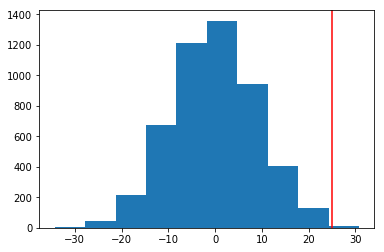

In [40]:
plt.hist(experiments)
plt.axvline(x=ate, color = 'red')

In [43]:
p_value(ate=ate, experiments=experiments)

0.0042000000000000006

In [44]:
np.sum(experiments > ate)

10